<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/working_with_data_from_w%26b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer 
import glob
import torch.optim as optim
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

import requests
import zipfile
from pathlib import Path

if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

In [164]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [47]:
!pip install wandb -qq
import wandb
wandb.login()
run = wandb.init(project="setup_weights and biases", job_type="download")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [48]:
data = run.use_artifact("ecg_25000.zip:latest")
data=data.download()

wandb: Downloading large artifact ecg_25000.zip:latest, 1383.92MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


In [49]:
# Setup path to data folder
data_path = Path("data/")
train_path = data_path / "train_data"


# If the image folder doesn't exist, download it and prepare it... 
if train_path.is_dir():
    print(f"{train_path} directory exists.")
else:
    print(f"Did not find {train_path} directory, creating one...")
    train_path.mkdir(parents=True, exist_ok=True)

    # Unzip pizza, steak, sushi data
with zipfile.ZipFile("/content/artifacts/ecg_25000.zip:v0/ecg_25000.zip", "r") as zip_ref:
    print(f"Unzipping data to folder...") 
    zip_ref.extractall(train_path)

data/train_data directory exists.
Unzipping data to folder...


In [ ]:
# from tqdm.auto import tqdm
# max_list=[]
# data_dir_test="/content/data/train_data"
# #data_dir_train = "/content/data/train_data/sub_data/train"
# files=glob.glob(data_dir_test + '/*.asc')
# #files_train=glob.glob(data_dir_train + '/*.asc')
# #files=[*files_test,*files_train]
# for file in tqdm(files):
#   temp_df=pd.read_csv(file,sep=" ",header=None)
#   max=temp_df.max().max()
#   max_list.append(max)

In [50]:
# Create custom dataset class to load ECG data into dataset, containing 
# input tensor with lead 1 and output tensor with desired other leads
class Custom_dataset(Dataset):
    def __init__(self, data_dir,max_value=5011,column=3,split=False,target="train"):
      #get all files from directory loaded in all_files list
      self.column=column
      self.max_value=max_value
      #should shuffle the data here?
      self.files = glob.glob(data_dir + '/*.asc')
      self.len=len(self.files)
      self.cut1=int(self.len*0.8)
      self.cut2=int(self.len*0.9)
      self.train_files=self.files[0:self.cut1]
      self.test_files=self.files[self.cut1:self.cut2]
      self.val_files=self.files[self.cut2:self.len]
      self.target=target
      self.split=split

    def __len__(self):
      if self.split is True:
        if self.target is "train":
          return len(self.train_files)
        if self.target is "test":
          return len(self.test_files)
        if self.target is "val":
          return len(self.val_files)
      if self.split is not True:
        return len(self.files)

    def __getitem__(self,idx):
      header = [x for x in range(8)]
      #turn list of dataframes into Tensor
      if self.split is True:
        if self.target is "train":
          temp_df=pd.read_csv(self.train_files[idx],sep=" ", names = header)
        if self.target is "test":
          temp_df=pd.read_csv(self.test_files[idx],sep=" ", names = header)
        if self.target is "val":
          temp_df=pd.read_csv(self.val_files[idx],sep=" ", names = header)
      if self.split is not True:
        temp_df=pd.read_csv(self.files[idx],sep=" ", names = header)
      temp_df/=self.max_value
      #load input tensor
      
      temp_list_in=temp_df.iloc[:,0]
      #temp_list_in=normalize([temp_list_in], norm="max")
      temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.float32)
      temp_tensor_in=temp_tensor_in.unsqueeze(0)
      #load label Tensor
      temp_list_out=temp_df.iloc[:,1:9].values
      #temp_list_out=normalize([temp_list_out], norm="max")
      temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.float32)
      temp_tensor_out=temp_tensor_out.unsqueeze(0)
      temp_tensor_out=torch.permute(temp_tensor_out,(0,2,1))
      #combine input and label and output
      temp_tensor_pair= temp_tensor_in,temp_tensor_out
      return temp_tensor_pair

In [51]:
data_dir="/content/data/train_data"
train_dataset = Custom_dataset(data_dir=data_dir,split=True,target="train")
test_dataset = Custom_dataset(data_dir=data_dir,split=True,target="test")
val_dataset = Custom_dataset(data_dir=data_dir,split=True,target="val")
len(train_dataset),len(test_dataset),len(val_dataset)

from torch.utils.data.dataloader import DataLoader
BATCH_SIZE = 128
#turn datasets into iterables
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )
val_dataloader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                             drop_last=True
                              )

In [52]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 20,
  "batch_size": 128
}

In [169]:
"""
Here, we define the autoencoder model.This model is taken from "https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py"
"""
class ECG_AE_v1(nn.Module):
    def __init__(self,step1=128,step2=64,step3=20):
        super(ECG_AE_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(5000,step1),
            nn.ReLU(),
            nn.Linear(step1,step2),
            nn.ReLU(),
            nn.Linear(step2,step3),
            nn.ReLU(),

        )
        self.decoder = nn.Sequential(

            nn.Linear(step3,step2),
            nn.ReLU(),
            nn.Linear(step2,step1),
            nn.ReLU(),
            nn.Linear(step1,35000),
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = ECG_AE_v1().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [168]:
model

ECG_AE_v1(
  (encoder): Sequential(
    (0): Linear(in_features=5000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=20, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=35000, bias=True)
  )
)

In [54]:
def get_pred(dataset=val_dataset):
  """
  takes a random index, takes data from dataset, lets model predict and saves data in CSV table
  """
  import random
  limit=len(dataset)
  rand_idx=random.randint(0,limit)
  X,y=dataset[rand_idx]
  model.to("cpu")
  model.eval()
  with torch.inference_mode():
    output=model(X)
    print(output.shape)
    output=torch.reshape(output,(5000, 7))
    print(output.shape)
  output=output.detach().numpy()
  #output=output.tolist()
  #header = [x for x in range(8)]
  df = pd.DataFrame(output,columns=["2","v1","v2","v3","v4","v5","v6"])*5011
  return df

In [148]:
def get_img(df,epoch,path):
  df=df
  columns=df.columns
  fig,axs = plt.subplots(7,1,figsize=(50,15))
  #plt.figure(figsize=(10,6))
  plt.suptitle(f"leads 2 to 8 from epoch{epoch}",x=0.5, y=0.93, fontsize=17, fontweight='700')
  for i,column in enumerate(columns):
    axs[i].plot(df[column], 'g', linewidth=2)
    axs[i].set_title(f'Plot {i}: lead {column}', fontsize=15)
  plt.xlabel('X[time in Datapoints]', fontsize=15, fontweight='bold')
  plt.ylabel('Y[mV]', fontsize=15, y=1, fontweight='bold')
  fig.savefig(path)   # save the figure to file
  plt.close(fig)

In [62]:
model_path = Path("/content/model/output")
save=model_path/"model"
save

PosixPath('/content/model/output/model')

In [162]:
def train_model(Epochs=20,model=model,train_dataloader=train_dataloader,val_dataloader=val_dataloader,stop=False):
  MODEL_NAME = "AE_test_wb"
  cfg = wandb.config
  model_path = Path("/content/model/output")
  model_path.mkdir(parents=True, exist_ok=True)
  # epoch_count = []
  # test_count = []
  # train_count = []
  from tqdm.auto import tqdm
  #train and test loop
  for epoch in tqdm(range(Epochs)):
    print(f"Epoch:{epoch}")
    train_loss=0
    for batch, (X,y) in enumerate(tqdm(train_dataloader)):
      #print("doing train loop")
      X, y = X.to(device), y.to(device) 
      model.train()
      output=model(X)
      output=torch.reshape(output,(128, 1, 7, 5000))
      #print(output.shape,y.shape)
      loss = criterion(output,y)
      #print(loss)
      train_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if stop is not False:
        if batch == stop:
          break
      #print(train_loss)
    #average loss per batch
    train_loss /= len(train_dataloader)
    #start testing
    val_loss = 0
    model.eval()
    with torch.inference_mode():
      for batch,(X,y) in enumerate(val_dataloader):
        #print("doing test loop")
        X, y = X.to(device), y.to(device)
        val_pred = model(X)
        val_pred=torch.reshape(val_pred,(128, 1, 7, 5000))
        val_loss += criterion(val_pred,y)   
      if stop is not False:
        if batch == stop:
          break
      val_loss /= len(val_dataloader)
    #logging train and val los to w&b
    if epoch % 1 == 0:
      #print(f"\nTrain loss: {train_loss:.5f} |test_loss:{test_loss}" )
      # epoch_count.append(epoch)
      # test_count.append(test_loss.item())
      # train_count.append(train_loss.item())
      wandb.log({"train_loss": train_loss,
                "val_loss":val_loss})
      wandb.watch(model)
    #safing model to w%b
    if epoch % 1 == 0:
      model_path.mkdir(parents=True, exist_ok=True)
      torch.save(model.state_dict(),model_path/MODEL_NAME )
      trained_model_artifact = wandb.Artifact(
            MODEL_NAME, type="model",
            description="test run for w&b",
            metadata=dict(cfg))
      trained_model_artifact.add_dir(model_path)
      run.log_artifact(trained_model_artifact)
    #   training_progress = pd.DataFrame(
    # {'Epoch': epoch_count,
    #  'Train_loss': train_count,
    #  'Test_loss': test_count
    # })
    #   training_progress.to_csv("/content/gdrive/MyDrive/Simula/model_outcome/progress.csv")
    #saving prediction csv files and prediction img files to WB
    if epoch % 1 == 0:
      predictions = get_pred(test_dataset)
      predictions.to_csv(model_path/"prediction.csv")
      pred_table = wandb.Artifact("Prediction_table", type="Table")
      pred_table.add_file(model_path/"prediction.csv")
      run.log_artifact(pred_table)
      get_img(df=predictions,epoch=epoch,path=model_path/"img.png")
      img_artifact=wandb.Artifact("Prediction_Images",type="Image")
      img_artifact.add_file(model_path/"img.png")
      run.log_artifact(img_artifact)


      #predictions.to_csv(f"/content/gdrive/MyDrive/Simula/model_outcome/predictions{epoch}.csv")


In [170]:
train_model(20,stop=5)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0


  0%|          | 0/156 [00:00<?, ?it/s]

wandb: Adding directory to artifact (/content/model/output)... Done. 0.3s


torch.Size([1, 35000])
torch.Size([5000, 7])
Epoch:1


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [116]:
df=get_pred()
columns=df.columns
for i,column in enumerate(columns):
  print(i,column)


torch.Size([1, 35000])
torch.Size([5000, 7])
0 2
1 v1
2 v2
3 v3
4 v4
5 v5
6 v6


In [155]:
df=get_pred()
epoch=2
path=Path("/content/img")
img = get_img(df,epoch,path/"img.png")

torch.Size([1, 35000])
torch.Size([5000, 7])


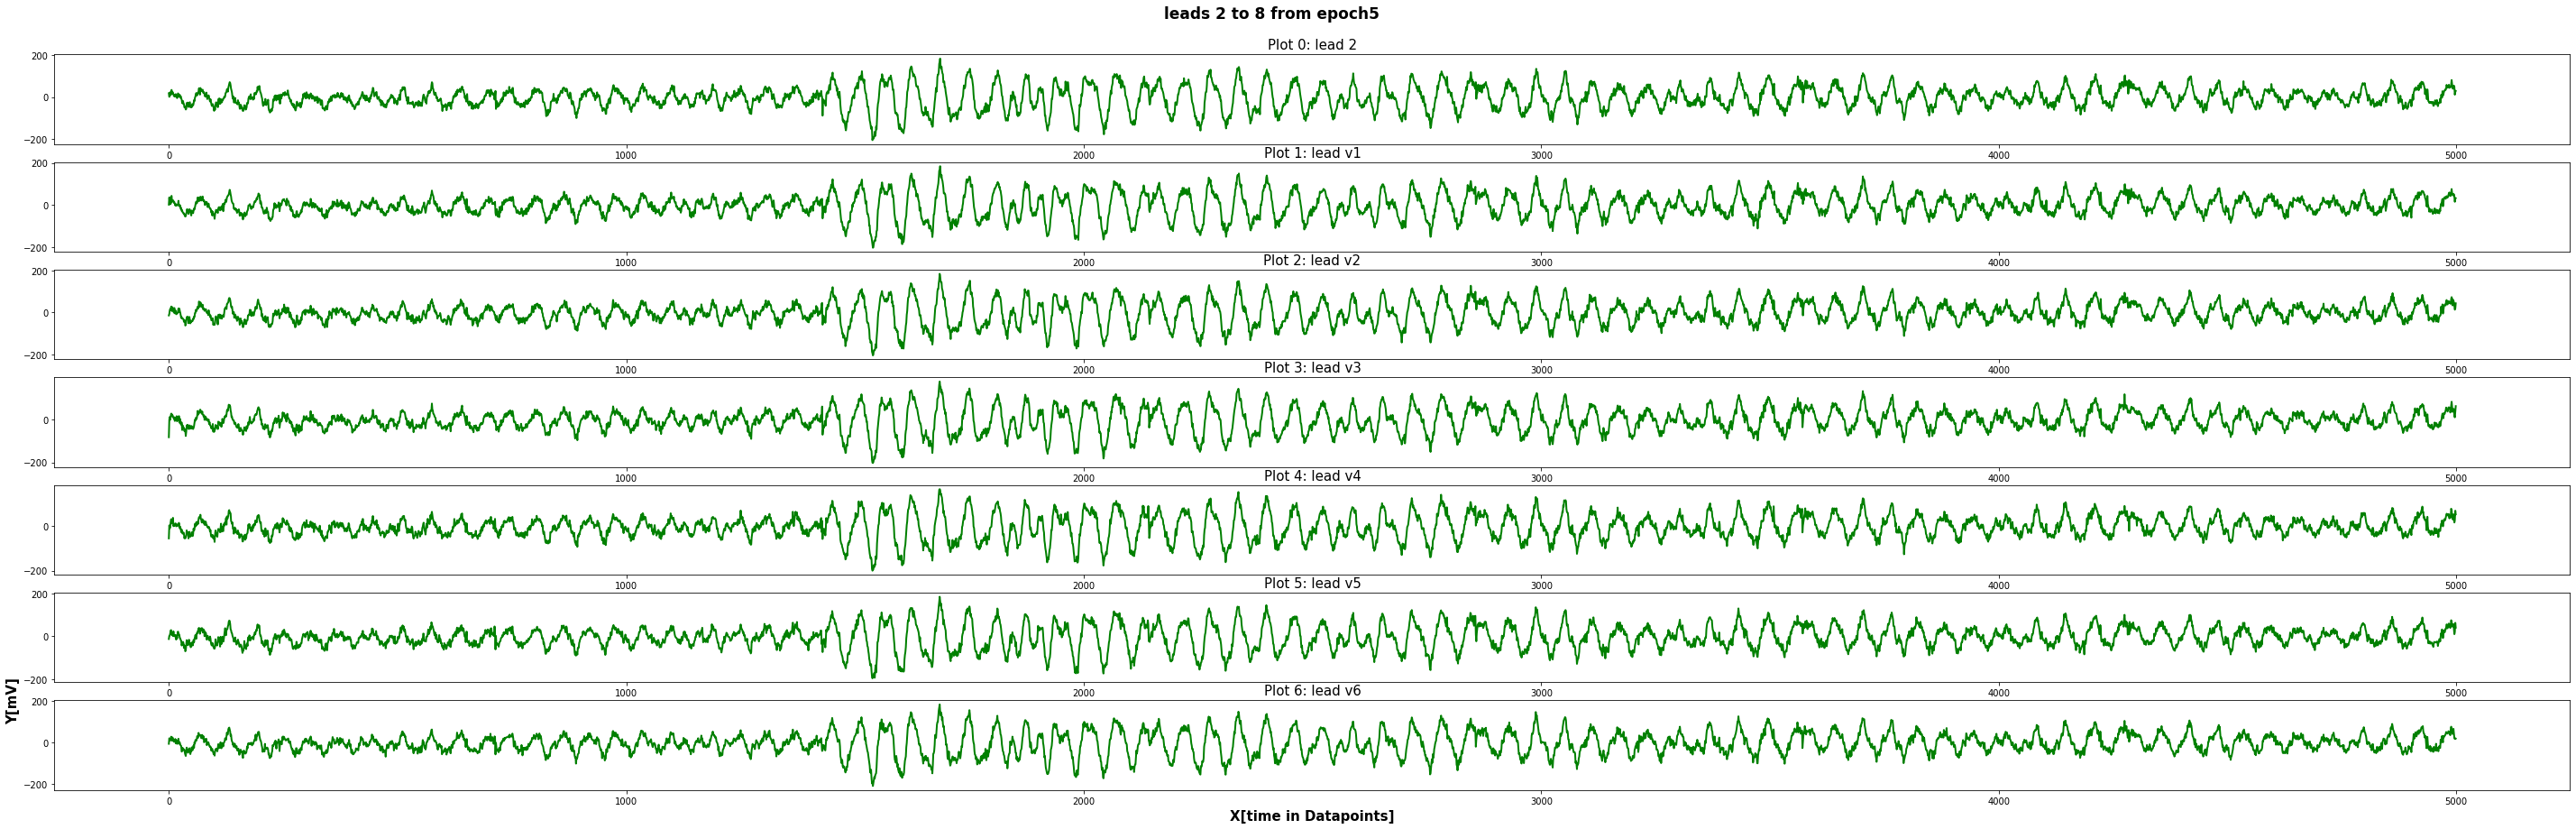

In [142]:
img